2023/04/23

# 概要

- PyTorch (+ GPU) の環境構築手順とサンプルコード
  - `環境構築.ipynb` が長くなりすぎたので最小限の内容で作り直したものです．
  - ※個人的に研究用途ではTensorFlowよりPyTorch推奨．
- 対応OS: Windows/Ubuntu
  - Ubuntuのほうが実験的に明らかに高速なので推奨します．

# 環境構築


## 1. NVIDIA driver のインストール
CPUでやる場合不要．

### Windows
- [GeForce Experience アプリ](https://www.nvidia.com/ja-jp/geforce/geforce-experience/) を使うと自動で更新通知が来て楽（要ユーザ登録）．
  - 手動でやる場合：ドライバ単体を https://www.nvidia.co.jp/Download/index.aspx?lang=jp から落としてもよい．
- インストール後再起動し，`> nvidia-smi` が動くか確認．
### Ubuntu
```$ sudo apt install nvidia-driver-525```
- インストール後再起動し，`> nvidia-smi` が動くか確認．
- 補足：`$ ubuntu-drivers devices` で確認できるもののうち，recommendedと付いているもの．ただし末尾の`-open`などは消す．

## 2. PyTorchのインストール
- https://pytorch.org/ で自分の環境に合わせたインストールコマンドを取得し，実行するだけ．
- たとえば Stable (2.0.0) + Windows + Pip + Python + CUDA 11.8 なら
```sh
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
- CUDA, cuDNN も一緒に入るのでインストール不要．

# サンプルコード

In [1]:
# バージョン確認．CPU版の場合 "+cu118" のような表記がないことに注意．
import torch
torch.__version__

'2.0.0+cu118'

In [2]:
# CUDAが使えることを確認
torch.cuda.is_available()

True

In [3]:
# MNISTデータセットの読み込み
from torchvision import transforms, datasets
data_tr = datasets.MNIST("~/data/", train=True,  transform=transforms.ToTensor(), download=True)
data_te = datasets.MNIST("~/data/", train=False, transform=transforms.ToTensor(), download=True)

torch.Size([1, 28, 28])
5


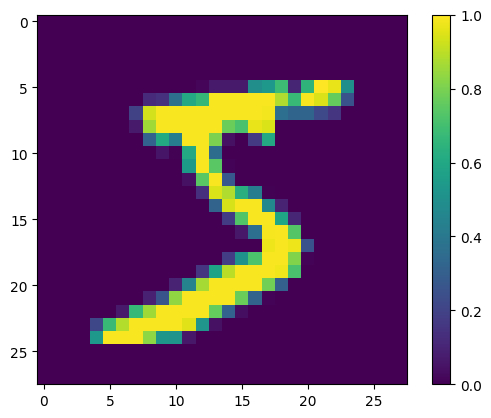

In [4]:
# 最初のデータを確認
x0, y0 = data_tr[0]
print(x0.shape) # 入力：(channels, height, width)
print(y0)       # 出力：整数

# 画像の確認
import matplotlib.pyplot as plt
plt.imshow(x0[0])   # 白黒なので0チャンネル目だけ描画
plt.colorbar()      # 画素値∈[0, 1]

In [5]:
# ミニバッチ化
loader_tr = torch.utils.data.DataLoader(data_tr, batch_size=256, shuffle=True)
loader_te = torch.utils.data.DataLoader(data_te, batch_size=256, shuffle=True)

In [6]:
# 最初のバッチを確認（データをバッチサイズ分並べただけ）
for x0, y0 in loader_tr:
    break
print(x0.shape)
print(y0.shape)
print(y0[:5])

torch.Size([256, 1, 28, 28])
torch.Size([256])
tensor([9, 5, 7, 7, 5])


In [7]:
# モデル定義（単純な多層パーセプトロン）
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 1024) # 線形層
        self.fc2 = torch.nn.Linear(1024, 1024)  # 線形層
        self.fc3 = torch.nn.Linear(1024, 10)    # 線形層
        self.criterion = torch.nn.CrossEntropyLoss()            # 損失関数
        self.optimizer = torch.optim.Adam(self.parameters())    # 最適化手法
        self.cuda() # GPUメモリへ転送

    def forward(self, x):
        x = x.view(-1, 28*28)   # (N, 1, 28, 28) -> (N, 28*28)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        return x
    
    def fit(self):
        for batch, (x, y) in enumerate(loader_tr, 1):
            x, y = x.cuda(), y.cuda()   # GPUメモリへ転送
            p = self(x)                 # 順伝播
            loss = self.criterion(p, y) # 損失計算
            self.optimizer.zero_grad()  # 勾配初期化
            loss.backward()             # 逆伝播
            self.optimizer.step()       # 更新
            print(f"\r{batch} / {len(loader_tr)}", end="")
    
    @torch.no_grad()    # テスト時は勾配計算を省略して高速化
    def test(self):
        p = self(data_te.data.cuda()/255)               # 推論
        y = data_te.targets.cuda()                      # 正解
        loss = self.criterion(p, y).item()              # 損失
        acc = (p.argmax(1) == y).float().mean().item()  # 精度
        return loss, acc

In [8]:
%%time
model = MLP()                   # モデルのインスタンス化
for epoch in range(1, 11):
    model.fit()                 # 訓練
    loss, acc = model.test()    # テスト
    print(f"\t[{epoch:2} / 10] loss: {loss:.4f} - acc: {acc:.4f}")

235 / 235	[ 1 / 10] loss: 0.1264 - acc: 0.9614
235 / 235	[ 2 / 10] loss: 0.0788 - acc: 0.9748
235 / 235	[ 3 / 10] loss: 0.0646 - acc: 0.9794
235 / 235	[ 4 / 10] loss: 0.0628 - acc: 0.9811
235 / 235	[ 5 / 10] loss: 0.0756 - acc: 0.9765
235 / 235	[ 6 / 10] loss: 0.0681 - acc: 0.9808
235 / 235	[ 7 / 10] loss: 0.0811 - acc: 0.9796
235 / 235	[ 8 / 10] loss: 0.0741 - acc: 0.9814
235 / 235	[ 9 / 10] loss: 0.0823 - acc: 0.9792
235 / 235	[10 / 10] loss: 0.0891 - acc: 0.9791
CPU times: total: 34.3 s
Wall time: 1min 27s
